In [11]:
 ! pip install -q kaggle

In [12]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"puneethkashyap","key":"f6c854855451f8d50fdfece0c5e4c200"}'}

In [13]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json

In [15]:
 ! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-14 18:29:44           3742  
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               626KB  2021-01-17 12:34:27           2305  
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21           1983  
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14            512  
google/android-smartphones-high-accuracy-datasets   

In [16]:
!kaggle datasets download -d kazanova/sentiment140

 83% 67.0M/80.9M [00:00<00:00, 69.9MB/s]
100% 80.9M/80.9M [00:01<00:00, 83.5MB/s]


In [17]:
!unzip \*.zip  && rm *.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [18]:
!mv /content/training.1600000.processed.noemoticon.csv /content/sent.csv

IMPORTS

In [48]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

STOPWORDS

In [20]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

DATASET

In [21]:
cols = ['sentiment','id','date','query_string','user','tweet']
df = pd.read_csv('/content/sent.csv',header=None,names=cols,encoding ='latin-1')
df.head()

,sentiment,id,date,query_string,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


PREPROCESSING

In [22]:
df.drop(['id','date','query_string','user'],axis =1,inplace=True)
print(df.head())
df.sentiment.value_counts()

   sentiment                                              tweet
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....


4    800000
0    800000
Name: sentiment, dtype: int64

In [23]:
df[df.sentiment==4].head()

,sentiment,tweet
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


Max length for a tweet is 140 characters....giving the benefit of doubt beacause of encoding, we remove data with more than 200 characters

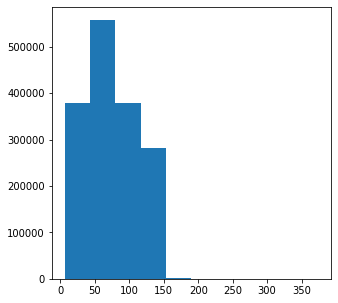

In [24]:
df['pre_clean_length'] = [len(txt) for txt in df.tweet]
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(df.pre_clean_length)
plt.show()

CLEANING

In [25]:
tokenizer = Tokenizer()
clean_tweets = []
for i in range(len(df.tweet)):
  soup = BeautifulSoup(df.tweet[i],'lxml')
  souped = soup.get_text()
  clean_1 = re.sub(r' @[A-Za-z0-9]+ | https?://[A-Za-z0-9./]+','',souped)
  try:
    clean_2 = clean_1.replace('ï¿½','')
  except:
    clean_2 = clean_1
  letters_only = re.sub("[^a-zA-Z]",' ',clean_2)
  lower_case = letters_only.lower()
  final_clean = re.sub('\s+',' ',lower_case)
  final_result = ' '.join([word for word in final_clean.split() if word not in stopwords])
  clean_tweets.append(final_result.strip())
  if (i%10000)==0:
    print (str(i)+'Tweets Completed')


0Tweets Completed
10000Tweets Completed
20000Tweets Completed
30000Tweets Completed
40000Tweets Completed
50000Tweets Completed
60000Tweets Completed
70000Tweets Completed
80000Tweets Completed
90000Tweets Completed
100000Tweets Completed
110000Tweets Completed
120000Tweets Completed
130000Tweets Completed
140000Tweets Completed
150000Tweets Completed
160000Tweets Completed
170000Tweets Completed
180000Tweets Completed
190000Tweets Completed
200000Tweets Completed
210000Tweets Completed
220000Tweets Completed
230000Tweets Completed
240000Tweets Completed
250000Tweets Completed
260000Tweets Completed
270000Tweets Completed
280000Tweets Completed
290000Tweets Completed
300000Tweets Completed
310000Tweets Completed
320000Tweets Completed
330000Tweets Completed
340000Tweets Completed
350000Tweets Completed
360000Tweets Completed
370000Tweets Completed
380000Tweets Completed
390000Tweets Completed
400000Tweets Completed
410000Tweets Completed
420000Tweets Completed
430000Tweets Completed
44

In [26]:
clean_df = pd.DataFrame(clean_tweets,columns=['tweets'])
clean_df['value'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

CUSTOM WORD EMBEDDING USING WORD2VEC GENSIM

In [39]:
# WORD2VEC 
W2V_SIZE = 500
W2V_WINDOW = 3
W2V_EPOCH = 32
W2V_MIN_COUNT = 20

# KERAS
SEQUENCE_LENGTH = 150
EPOCHS = 8
BATCH_SIZE = 1024

In [29]:
clean_df = pd.read_csv('/content/clean_tweet.csv',index_col=False)
clean_df = clean_df[['tweets','value']]
clean_df.head()

,tweets,value
0,switchfoot awww s bummer shoulda got david car...,0
1,upset can t update facebook texting might cry ...,0
2,kenichan dived many times ball managed save re...,0
3,whole body feels itchy like fire,0
4,nationwideclass no s not behaving m mad can t see,0


In [30]:
f={0 : 'Negative', 4 : 'Positive'}
def sentiment_decoder(value):
    return f[value]

clean_df.value = clean_df.value.apply(lambda x: sentiment_decoder(x))

In [35]:
clean_df.tweets = clean_df.tweets.astype(str)
clean_df.head()

,tweets,value
0,switchfoot awww s bummer shoulda got david car...,Negative
1,upset can t update facebook texting might cry ...,Negative
2,kenichan dived many times ball managed save re...,Negative
3,whole body feels itchy like fire,Negative
4,nationwideclass no s not behaving m mad can t see,Negative


In [36]:
dt_train, dt_test = train_test_split(clean_df, test_size=0.2, random_state=42)

CUSTOM WORD2VEC WORD EMBEDDING

In [31]:
corpus = [_text.split() for _text in dt_train.tweets] 

In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [33]:
w2v_model.build_vocab(corpus)

In [34]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 21431


In [35]:
w2v_model.train(corpus, total_examples=len(corpus), epochs=W2V_EPOCH)

(276853327, 338887840)

In [36]:
w2v_model.save("word2vec.model")

In [3]:
w2v_model = gensim.models.Word2Vec.load("word2vec.model")

In [4]:
w2v_model.wv.most_similar("mad")

[('upset', 0.45091286301612854),
 ('angry', 0.40851595997810364),
 ('pissed', 0.40404877066612244),
 ('sad', 0.40070512890815735),
 ('bummed', 0.3541557788848877),
 ('hungry', 0.3481699824333191),
 ('annoyed', 0.34607017040252686),
 ('sick', 0.34031951427459717),
 ('irritated', 0.33422356843948364),
 ('bored', 0.3323625326156616)]

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dt_train.tweets)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 487942


In [40]:
x_train = pad_sequences(tokenizer.texts_to_sequences(dt_train.tweets), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(dt_test.tweets), maxlen=SEQUENCE_LENGTH)

In [41]:
labels = dt_train.value.unique().tolist()

In [42]:
encoder = LabelEncoder()
encoder.fit(dt_train.value.tolist())

y_train = encoder.transform(dt_train.value.tolist())
y_test = encoder.transform(dt_test.value.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


EMBEDDING LAYER

In [43]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(487942, 500)


In [46]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [49]:
learning_rate_reduction = [ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)]

In [52]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
#LSTM 
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100 , return_sequences = True, dropout = 0.2)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100 , dropout = 0.1)))
model.add(tf.keras.layers.Dense(units = 32 , activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
history = model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE, 
                    validation_split=0.1,
                    epochs = 4, #EPOCHS, 
                    callbacks = learning_rate_reduction)

Epoch 1/4
1125/1125 [==============================] - 533s 462ms/step - loss: 0.4522 - accuracy: 0.7853 - val_loss: 0.4118 - val_accuracy: 0.8101
Epoch 2/4
1125/1125 [==============================] - 526s 467ms/step - loss: 0.4090 - accuracy: 0.8121 - val_loss: 0.4079 - val_accuracy: 0.8132
Epoch 3/4
1125/1125 [==============================] - 526s 467ms/step - loss: 0.4048 - accuracy: 0.8138 - val_loss: 0.4064 - val_accuracy: 0.8132
Epoch 4/4
1125/1125 [==============================] - 526s 467ms/step - loss: 0.4022 - accuracy: 0.8156 - val_loss: 0.4059 - val_accuracy: 0.8141


In [54]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [55]:
!zip -r /content/file.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 90%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 69%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 95%)


In [56]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 62s 195ms/step - loss: 0.4056 - accuracy: 0.8139

ACCURACY: 0.8138718605041504
LOSS: 0.4056333303451538


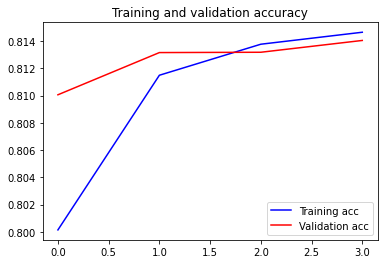

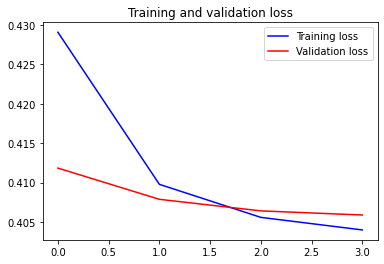

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()